In [131]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import math
import plotly.graph_objects as go


In [74]:
data = pd.read_csv('microsoft_cleaned_data.csv')

# Convert Date to datetime and set it as the index
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [75]:
def compute_bollinger_bands(series, window):
	rolling_mean = series.rolling(window=window).mean()
	rolling_std = series.rolling(window=window).std()
	upper_band = rolling_mean + (rolling_std * 2)
	lower_band = rolling_mean - (rolling_std * 2)
	return upper_band, lower_band

data['MA5'] = data['High'].rolling(window=5).mean()
data['MA10'] = data['High'].rolling(window=10).mean()
data['MA20'] = data['High'].rolling(window=20).mean()

# Exponential Moving Average for 20 days for High price to smooth the data
data['EMA'] = data['High'].ewm(span=20, adjust=False).mean()

# Bollinger Bands to identify overbought and oversold conditions
data['BB_upper'], data['BB_lower'] = compute_bollinger_bands(data['High'], window=20)

data = data[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'MA5', 'MA10', 'MA20', 'EMA', 'BB_upper', 'BB_lower']]
data.head(30)

,Open,High,Low,Close,Adj Close,Volume,MA5,MA10,MA20,EMA,BB_upper,BB_lower
Date,,,,,,,,,,,,
2010-01-04,30.620001,31.100000,30.590000,30.950001,23.474922,38409100,NaN,NaN,NaN,31.100000,NaN,NaN
2010-01-05,30.850000,31.100000,30.639999,30.959999,23.482502,49749600,NaN,NaN,NaN,31.100000,NaN,NaN
2010-01-06,30.879999,31.080000,30.520000,30.770000,23.338396,58182400,NaN,NaN,NaN,31.098095,NaN,NaN
2010-01-07,30.629999,30.700001,30.190001,30.450001,23.095678,50559700,NaN,NaN,NaN,31.060182,NaN,NaN
2010-01-08,30.280001,30.879999,30.240000,30.660000,23.254963,51197400,30.972,NaN,NaN,31.043021,NaN,NaN
2010-01-11,30.709999,30.760000,30.120001,30.270000,22.959152,68754700,30.904,NaN,NaN,31.016067,NaN,NaN
2010-01-12,30.150000,30.400000,29.910000,30.070000,22.807459,65912100,30.764,NaN,NaN,30.957394,NaN,NaN
2010-01-13,30.260000,30.520000,30.010000,30.350000,23.019827,51863500,30.652,NaN,NaN,30.915737,NaN,NaN
2010-01-14,30.309999,31.100000,30.260000,30.959999,23.482502,63228100,30.732,NaN,NaN,30.933286,NaN,NaN


In [76]:
import plotly.graph_objects as go

# Plot High Price and Moving Averages
fig = go.Figure()
fig.add_trace(go.Scatter(x=data.index, y=data['High'], mode='lines', name='High Price'))
fig.add_trace(go.Scatter(x=data.index, y=data['MA5'], mode='lines', name='MA5'))
fig.add_trace(go.Scatter(x=data.index, y=data['MA10'], mode='lines', name='MA10'))
fig.add_trace(go.Scatter(x=data.index, y=data['MA20'], mode='lines', name='MA20'))
fig.update_layout(title='Microsoft Stock Price', xaxis_title='Date', yaxis_title='Price')
fig.show()

# Plot Moving Averages for the year 2021
data_2021 = data.loc['2023']

fig = go.Figure()
fig.add_trace(go.Scatter(x=data_2021.index, y=data_2021['MA5'], mode='lines', name='MA5'))
fig.add_trace(go.Scatter(x=data_2021.index, y=data_2021['MA10'], mode='lines', name='MA10'))
fig.add_trace(go.Scatter(x=data_2021.index, y=data_2021['MA20'], mode='lines', name='MA20'))
fig.update_layout(title='Moving Averages for 2023', xaxis_title='Date', yaxis_title='Price')
fig.show()

# Plot Bollinger Bands
fig = go.Figure()
fig.add_trace(go.Scatter(x=data.index, y=data['High'], mode='lines', name='High Price'))
fig.add_trace(go.Scatter(x=data.index, y=data['BB_upper'], mode='lines', name='BB Upper'))
fig.add_trace(go.Scatter(x=data.index, y=data['BB_lower'], mode='lines', name='BB Lower'))
fig.update_layout(title='Bollinger Bands', xaxis_title='Date', yaxis_title='Price')
fig.show()


In [77]:
# Keeping only relevant columns for training
data = data[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'MA5', 'MA10', 'MA20', 'EMA', 'BB_upper', 'BB_lower']]

# Dropping NaN values that may have been created by moving averages and Bollinger Bands
data.dropna(inplace=True)

# Splitting the dataset into training and testing sets
train = data[:'2020']
test = data['2021':]


In [78]:
# Scaling the data
sc = MinMaxScaler(feature_range=(0, 1))
train_scaled = sc.fit_transform(train)
test_scaled = sc.transform(test)

In [7]:
# Preparing training data
x_train, y_train = [], []
for i in range(60, len(train_scaled)):
    x_train.append(train_scaled[i-60:i])
    y_train.append(train_scaled[i, 1])  # Predicting 'High' which is the second column (index 1)

x_train, y_train = np.array(x_train), np.array(y_train)

# Reshaping x_train to be 3D
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2]))

In [79]:
print("x_train",x_train[0])

print("y_train",y_train[0])

print(len(x_train))

print(len(y_train))

print(x_train.shape) # Use slicing to get the first 5 elements

print(y_train.shape)

x_train [[0.02570569 0.02462537 0.02536409 0.0258819  0.0189742  0.25170708
  0.02826468 0.02984051 0.03150277 0.02992413 0.03236159 0.03296748]
 [0.0256087  0.02472082 0.02643925 0.02612155 0.01915711 0.15065489
  0.02695658 0.0284787  0.03083788 0.0290613  0.03278824 0.03111802]
 [0.02507518 0.02610481 0.02634152 0.02693635 0.01977885 0.17304788
  0.02595855 0.02741013 0.03024716 0.028421   0.03271489 0.02998102]
 [0.02565719 0.02472082 0.0248265  0.02314992 0.01688956 0.22579717
  0.02463107 0.02630677 0.02958739 0.02770133 0.03264822 0.02869404]
 [0.02381414 0.0236709  0.0236536  0.02401265 0.01754791 0.23576889
  0.02304197 0.0253525  0.02896853 0.02694372 0.03276981 0.02728087]
 [0.02386264 0.02271643 0.0236536  0.02257477 0.01645072 0.14554704
  0.02265438 0.02456723 0.0282525  0.02616146 0.03269501 0.02588688]
 [0.02366863 0.02395724 0.02453328 0.02396472 0.01751132 0.16598743
  0.02249935 0.02381674 0.02763365 0.02557955 0.03238491 0.02495669]
 [0.02395965 0.02348    0.0249731

In [80]:
# Creating the GRU model
# The GRU architecture
regressorGRU = Sequential()

# First GRU layer with Dropout regularization
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]), activation='tanh'))
regressorGRU.add(Dropout(0.2))

# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, activation='tanh'))
regressorGRU.add(Dropout(0.2))

# # Third GRU layer
# regressorGRU.add(GRU(units=50, return_sequences=True, activation='tanh'))
# regressorGRU.add(Dropout(0.2))

# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))

# # The output layer
regressorGRU.add(Dense(units=1))


Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - loss: 0.0013
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 0.0013
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 0.0014
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 0.0013
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 0.0013
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 0.0014
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0012
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - loss: 0.0011
Epoch 9/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - loss: 0.0011
Epoch 10/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 0.0013
Epoch 11/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - loss: 0.0013
Epoch 12/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 0.0011
Epoch 13/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - loss: 0.0011
Epoch 14/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - loss: 0.0012
Epoch 15/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - loss: 

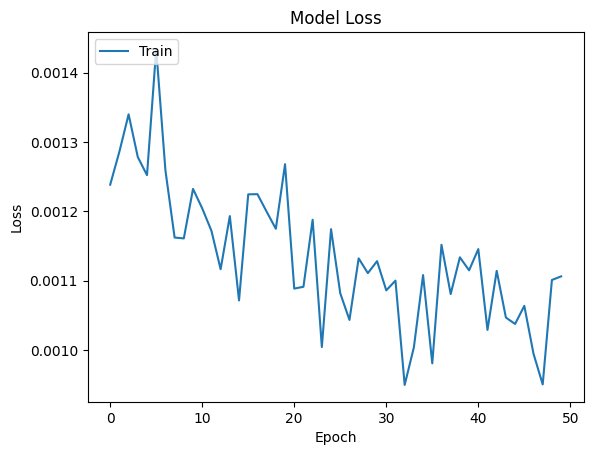

In [89]:
# Compiling the model
regressorGRU.compile(optimizer=SGD(learning_rate=0.01, decay=1e-7, momentum=0.9, nesterov=False), loss='mean_squared_error')

# Fitting the model
regressorGRU.fit(x_train, y_train, epochs=50, batch_size=160)

# Plot the loss graph
plt.plot(regressorGRU.history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


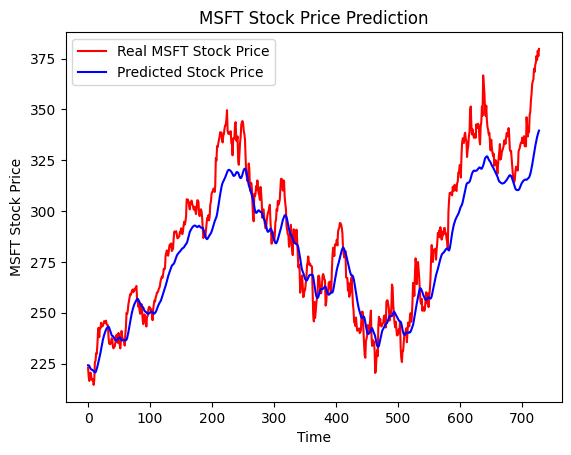

In [90]:
# Preparing the test set
inputs = data[len(data) - len(test) - 60:].values
inputs = sc.transform(inputs)

x_test = []
for i in range(60, len(inputs)):
    x_test.append(inputs[i-60:i])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], x_test.shape[2]))

# Predicting the stock prices
predicted_with_gru = regressorGRU.predict(x_test)

# Create an array to hold the predicted values with the correct shape
predicted_with_gru_reshaped = np.zeros((predicted_with_gru.shape[0], x_test.shape[2]))  # Same number of columns as input data
predicted_with_gru_reshaped[:, 1] = predicted_with_gru.flatten()  # Assign predicted values to the "High" column

# Inverse transform the predictions
predicted_with_gru = sc.inverse_transform(predicted_with_gru_reshaped)[:, 1]  # Only take the "High" column

# Visualization of predictions
def plot_predictions(test, predicted):
    plt.plot(test, color="red", label="Real MSFT Stock Price")
    plt.plot(predicted, color="blue", label="Predicted Stock Price")
    plt.title("MSFT Stock Price Prediction")
    plt.xlabel("Time")
    plt.ylabel("MSFT Stock Price")
    plt.legend()
    plt.show()

plot_predictions(test['High'].values, predicted_with_gru)


                Actual   Predicted
Date                              
2021-01-04  223.000000  224.184255
2021-01-05  218.520004  224.149709
2021-01-06  216.490005  223.836371
2021-01-07  219.339996  223.112464
2021-01-08  220.580002  222.470488
                Actual   Predicted
Date                              
2023-11-16  376.350006  335.035671
2023-11-17  374.369995  336.502469
2023-11-20  378.869995  337.662724
2023-11-21  376.220001  338.676227
2023-11-22  379.790009  339.607973


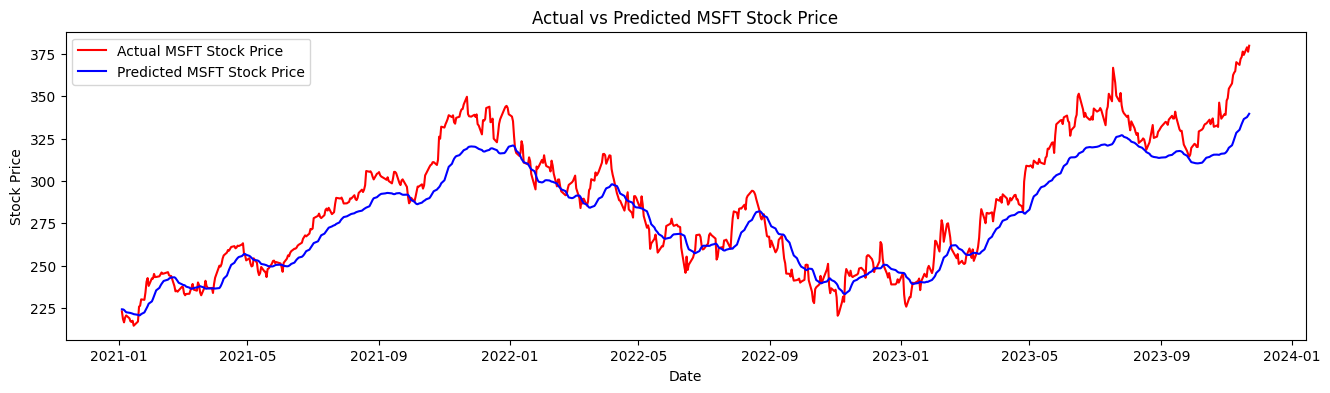

In [91]:
# Ensure the lengths of test and predicted_with_gru match
actual_values = test['High'].values[:len(predicted_with_gru)]

# Create a DataFrame to store the actual and predicted values
comparison_df = pd.DataFrame({
    'Actual': actual_values,
    'Predicted': predicted_with_gru
}, index=test.index[:len(predicted_with_gru)])

# Display the DataFrame in table format
print(comparison_df.head())
print(comparison_df.tail())

# Plot the actual vs predicted values
plt.figure(figsize=(16, 4))
plt.plot(comparison_df['Actual'], label='Actual MSFT Stock Price', color='red')
plt.plot(comparison_df['Predicted'], label='Predicted MSFT Stock Price', color='blue')
plt.title('Actual vs Predicted MSFT Stock Price')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [92]:
# Calculate MAE, MSE, and RMSE
actual_values = test['High'].values[:len(predicted_with_gru)]
mae = mean_absolute_error(actual_values, predicted_with_gru)
mse = mean_squared_error(actual_values, predicted_with_gru)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 11.379471516093412
Mean Squared Error (MSE): 203.77090897197488
Root Mean Squared Error (RMSE): 14.27483481417473


In [127]:
# Save the model
regressorGRU.save('gru_model_v2.h5')

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


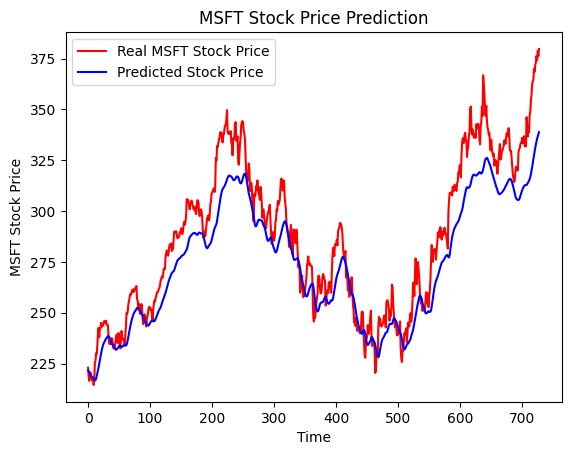

Mean Absolute Error (MAE): 13.32664648932041
Mean Squared Error (MSE): 263.80639799056996
Root Mean Squared Error (RMSE): 16.2421180266174


In [86]:
# Load the saved model
loaded_model = tf.keras.models.load_model('gru_model.h5')

# Preparing the test set
inputs = data[len(data) - len(test) - 60:].values
inputs = sc.transform(inputs)

x_test = []
for i in range(60, len(inputs)):
    x_test.append(inputs[i-60:i])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], x_test.shape[2]))

# Predicting the stock prices using the loaded model
predicted_with_loaded_model = loaded_model.predict(x_test)

# Create an array to hold the predicted values with the correct shape
predicted_with_loaded_model_reshaped = np.zeros((predicted_with_loaded_model.shape[0], x_test.shape[2]))  # Same number of columns as input data
predicted_with_loaded_model_reshaped[:, 1] = predicted_with_loaded_model.flatten()  # Assign predicted values to the "High" column

# Inverse transform the predictions
predicted_with_loaded_model = sc.inverse_transform(predicted_with_loaded_model_reshaped)[:, 1]  # Only take the "High" column

# Visualization of predictions
def plot_predictions(x_test, predicted):
    plt.plot(x_test, color="red", label="Real MSFT Stock Price")
    plt.plot(predicted, color="blue", label="Predicted Stock Price")
    plt.title("MSFT Stock Price Prediction")
    plt.xlabel("Time")
    plt.ylabel("MSFT Stock Price")
    plt.legend()
    plt.show()

# Visualization of predictions
plot_predictions(test['High'].values[:len(predicted_with_loaded_model)], predicted_with_loaded_model)

# Calculate MAE, MSE, and RMSE
actual_values = test['High'].values[:len(predicted_with_loaded_model)]
mae = mean_absolute_error(actual_values, predicted_with_loaded_model)
mse = mean_squared_error(actual_values, predicted_with_loaded_model)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


In [35]:
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings

# Ignore harmless warnings
warnings.filterwarnings("ignore")

# Use 'High' as the target variable and all other features as exogenous variables
exog_features = data.drop(columns=['High'])
target = data['High']

# Split the dataset into train/test sets based on the date
train_exog = exog_features.loc[:'2020-12-31']  #
test_exog = exog_features.loc['2021-01-01':]   # 

train_target = target.loc[:'2020-12-31']  # 
test_target = target.loc['2021-01-01':]   # 

# Fit auto_arima to find the best SARIMAX order with exogenous variables
stepwise_fit = auto_arima(train_target, exogenous=train_exog, start_p=1, start_q=1,
                          max_p=3, max_q=3, m=12, start_P=0, seasonal=True,
                          d=None, D=1, trace=True, error_action='ignore',
                          suppress_warnings=True, stepwise=True)

# Print the auto_arima model summary
print(stepwise_fit.summary())

# Get the best SARIMA order from auto_arima
order = stepwise_fit.order
seasonal_order = stepwise_fit.seasonal_order

# Fit the SARIMAX model with exogenous variables
sarimax_model = SARIMAX(train_target, 
                        exog=train_exog,
                        order=order,  # Non-seasonal part
                        seasonal_order=seasonal_order)  # Seasonal part

sarimax_result = sarimax_model.fit()
print(sarimax_result.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=7.57 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=14682.081, Time=0.15 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=13461.842, Time=0.82 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=4.31 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=14670.318, Time=0.20 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=13221.632, Time=1.37 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=6.36 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=4.00 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=13220.593, Time=0.98 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=13460.673, Time=0.81 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=7.17 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=2.23 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=13221.590, Time=2.00 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=inf, Time=10.45 sec
 ARIMA(0,1,0)(2,1,0)[12] intercept   : AIC=132

In [132]:
# Make predictions using the test exogenous features (2020 onwards)
start = len(train_target)
end = start + len(test_target) - 1

sarimax_predictions = sarimax_result.predict(start=start, end=end, exog=test_exog, typ='levels')
sarimax_predictions.name = "SARIMAX Predictions"

# Create a plotly figure
fig = go.Figure()

# Add actual stock price trace
fig.add_trace(go.Scatter(x=test_target.index, y=test_target.values, mode='lines', name='Actual MSFT Stock Price', line=dict(color='red')))

# Add SARIMAX predicted stock price trace
fig.add_trace(go.Scatter(x=sarimax_predictions.index, y=sarimax_predictions.values, mode='lines', name='SARIMAX Predicted Price', line=dict(color='green')))

# Update layout
fig.update_layout(title='MSFT Stock Price SARIMAX Predictions (2021 onwards)',
                  xaxis_title='Time',
                  yaxis_title="MSFT Stock Price ('High')",
                  legend=dict(x=0, y=1))

# Show the figure
fig.show()

# Ensure the lengths of test and predicted_with_gru match
actual_values = test['High'].values[:len(predicted_with_gru)]

# Create a DataFrame to store the actual and predicted values
comparison_df = pd.DataFrame({
    'Actual': actual_values,
    'Predicted': predicted_with_gru
}, index=test.index[:len(predicted_with_gru)])

# Display the DataFrame in table format
print(comparison_df.head())
print(comparison_df.tail())


# # Plot predictions and actual values
# plt.plot(test_target.values, color="red", label="Actual MSFT Stock Price")
# plt.plot(sarimax_predictions.values, color="green", label="SARIMAX Predicted Price")
# plt.title("MSFT Stock Price SARIMAX Predictions (2021 onwards)")
# plt.xlabel("Time")
# plt.ylabel("MSFT Stock Price ('High')")
# plt.legend()
# plt.show()

                Actual   Predicted
Date                              
2021-01-04  223.000000  224.184255
2021-01-05  218.520004  224.149709
2021-01-06  216.490005  223.836371
2021-01-07  219.339996  223.112464
2021-01-08  220.580002  222.470488
                Actual   Predicted
Date                              
2023-11-16  376.350006  335.035671
2023-11-17  374.369995  336.502469
2023-11-20  378.869995  337.662724
2023-11-21  376.220001  338.676227
2023-11-22  379.790009  339.607973


In [ ]:
# Calculate MAE, MSE, and RMSE
# Ensure the lengths of actual_values and sarimax_predictions match
actual_values = test['High'].values[:len(sarimax_predictions)]

# Truncate sarimax_predictions to match the length of actual_values
sarimax_predictions = sarimax_predictions[:len(actual_values)]

mae = mean_absolute_error(actual_values, sarimax_predictions)
mse = mean_squared_error(actual_values, sarimax_predictions)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 50.96254096504072
Mean Squared Error (MSE): 4416.565824889049
Root Mean Squared Error (RMSE): 66.4572480989775


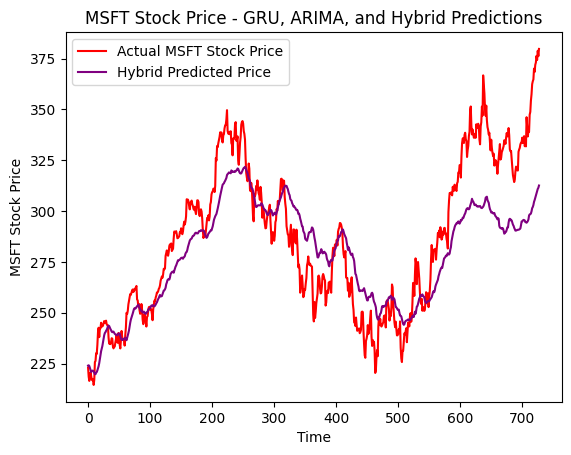

Mean Absolute Error (MAE): 17.095000611531873
Mean Squared Error (MSE): 484.774146989028
Root Mean Squared Error (RMSE): 22.01758721997095


In [100]:
# Ensure ARIMA predictions and GRU predictions have the same length
sarimax_predictions = np.array(sarimax_predictions[:len(predicted_with_gru)])

# Ensure ARIMA predictions and GRU predictions have the same length
min_length = min(len(predicted_with_gru), len(sarimax_predictions))
sarimax_predictions = sarimax_predictions[:min_length]
predicted_with_loaded_model = predicted_with_gru[:min_length]

# # Combine ARIMA and GRU predictions
# hybrid_predictions = (predicted_with_gru + sarimax_predictions) / 2

# Combine ARIMA and GRU predictions
hybrid_predictions = 0.8 * predicted_with_gru + 0.2 * sarimax_predictions

# Plot ARIMA, GRU, and hybrid predictions
plt.plot(test['High'].values, color="red", label="Actual MSFT Stock Price")
# plt.plot(predicted_with_loaded_model, color="blue", label="GRU Predicted Price")
# plt.plot(sarimax_predictions, color="green", label="ARIMA Predicted Price")
plt.plot(hybrid_predictions, color="purple", label="Hybrid Predicted Price")
plt.title("MSFT Stock Price - GRU, ARIMA, and Hybrid Predictions")
plt.xlabel("Time")
plt.ylabel("MSFT Stock Price")
plt.legend()
plt.show()

# Calculate MAE, MSE, and RMSE for ARIMA, GRU, and Hybrid predictions
actual_values = test['High'].values[:min_length]
mae = mean_absolute_error(actual_values, hybrid_predictions)
mse = mean_squared_error(actual_values, hybrid_predictions)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")



In [128]:
# Ensure the lengths of test and predicted_with_gru match
actual_values = test['High'].values[:len(hybrid_predictions)]

# Create a DataFrame to store the actual and predicted values
comparison_df = pd.DataFrame({
    'Actual': actual_values,
    'Predicted': hybrid_predictions
}, index=test.index[:len(hybrid_predictions)])

# Display the DataFrame in table format
print(comparison_df.head())
print(comparison_df.tail())

import plotly.graph_objects as go

# Create a plotly figure
fig = go.Figure()

# Add actual stock price trace
fig.add_trace(go.Scatter(x=comparison_df.index, y=comparison_df['Actual'], mode='lines', name='Actual MSFT Stock Price', line=dict(color='red')))

# Add predicted stock price trace
fig.add_trace(go.Scatter(x=comparison_df.index, y=comparison_df['Predicted'], mode='lines', name='Predicted MSFT Stock Price', line=dict(color='blue')))

# Update layout
fig.update_layout(title='Actual vs Predicted MSFT Stock Price with Hybrid Model',
                  xaxis_title='Date',
                  yaxis_title='Stock Price',
                  legend=dict(x=0, y=1))

# Show the figure
fig.show()

# # Plot the actual vs predicted values
# plt.figure(figsize=(16, 4))
# plt.plot(comparison_df['Actual'], label='Actual MSFT Stock Price', color='red')
# plt.plot(comparison_df['Predicted'], label='Predicted MSFT Stock Price', color='blue')
# plt.title('Actual vs Predicted MSFT Stock Price')
# plt.xlabel('Date')
# plt.ylabel('Stock Price')
# plt.legend()
# plt.show()

                Actual   Predicted
Date                              
2021-01-04  223.000000  224.012966
2021-01-05  218.520004  224.168269
2021-01-06  216.490005  223.796394
2021-01-07  219.339996  222.881489
2021-01-08  220.580002  221.837463
                Actual   Predicted
Date                              
2023-11-16  376.350006  308.711153
2023-11-17  374.369995  309.898112
2023-11-20  378.869995  310.908954
2023-11-21  376.220001  311.470450
2023-11-22  379.790009  312.597885


In [126]:
import joblib

# Save the ARIMA model
joblib.dump(sarimax_model, 'arima_model.pkl')

['arima_model.pkl']